# Backpack prediction Competition
[link](https://www.kaggle.com/competitions/playground-series-s5e2/overview)

In [290]:
%pip install kagglehub numpy Pillow scikit-learn torch torchvision matplotlib opencv-python pandas 1>/dev/null
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# Force CPU
# device = 'cpu'
print(f"Using {device} device")

%matplotlib inline


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: /home/pj/.pyenv/versions/py310_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using cuda device


## Load Data

In [118]:
A = np.array([1,2,3,4,5])
A // 2

array([0, 1, 1, 2, 2])

In [330]:
import kagglehub
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# Download the latest version of the dataset to the specified subdirectory.
dataset_path = kagglehub.competition_download("playground-series-s5e2")

print("Path to dataset files:", dataset_path)

# with open(f"{dataset_path}/train.csv", 'r') as f:
#     print(f.readlines())

raw_data = pd.read_csv(f"{dataset_path}/train.csv")
X_pd_raw = raw_data.copy().drop('Price', axis=1).drop('id', axis=1)
y_pd_raw = raw_data['Price']

y_price_class = y_pd_raw // 10

test_size = 0.00005
# test_size = 0.2

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_pd_raw, y_pd_raw, stratify=y_price_class, test_size=test_size
)

y_test_raw

Path to dataset files: /home/pj/.cache/kagglehub/competitions/playground-series-s5e2


69367      49.02723
193876    150.00000
147137    113.40680
126046    124.09221
100251    100.93298
275950     24.10931
205002     82.23117
213416     58.11345
270926     95.35144
240459     75.20157
124876     69.04962
201689    147.05262
294247     15.16178
195599     34.59734
228798    138.00157
Name: Price, dtype: float64

# Data Exploration

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Compartments'}>],
       [<Axes: title={'center': 'Weight Capacity (kg)'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

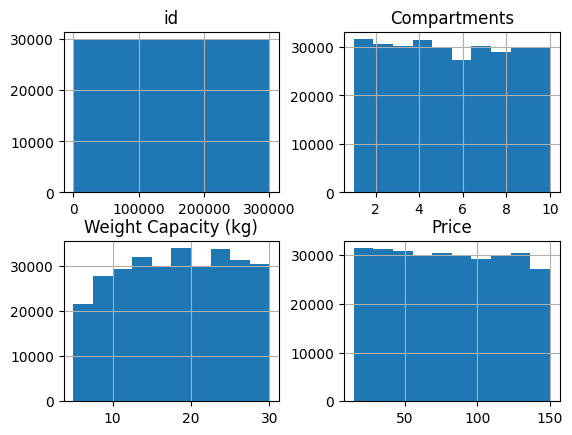

In [293]:
raw_data.hist(bins=10)

## Preprocessing

In [331]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

num_features = ['Compartments', 'Weight Capacity (kg)']
cat_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']

missing_cols = [
    col
    for col in X_pd.columns
    if (col not in num_features) and (col not in cat_features)
]
assert len(missing_cols) == 0, f"not all columns accounted for; missing {missing_cols}"

cat_pipeline = Pipeline(steps=[
    ('imputer_mf', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())
])

num_pipeline = Pipeline(steps=[
    ('imputer_mean', SimpleImputer(strategy="mean")),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'  # Drop any columns not specified (optional, default is 'drop')
)

full_pipeline.fit(X_train_raw)
X_train = full_pipeline.transform(X_train_raw)
X_test = full_pipeline.transform(X_test_raw)

# y_train_unscaled = y_train_raw.values.reshape(-1, 1)
# y_test_unscaled = y_test_raw.values.reshape(-1, 1)
# target_scaler = StandardScaler()
# target_scaler.fit(y_train_unscaled)
# y_train = target_scaler.transform(y_train_unscaled)
# y_test = target_scaler.transform(y_test_unscaled)

y_train = y_train_raw.values.reshape(-1, 1)
y_test = y_test_raw.values.reshape(-1, 1)


X_test

array([[0.77777778, 0.93484574, 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.44444444, 0.70591185, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        ],
       [0.55555556, 0.54387233, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.    

## Try Traditional

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

lin_reg = RandomForestRegressor()
lin_reg.fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
train_err = mean_squared_error(y_pred_train, y_train)

y_pred_test = lin_reg.predict(X_test)
test_err = mean_squared_error(y_pred_test, y_test)

print(f"{train_err=} {test_err=}")

/home/pj/.pyenv/versions/py310_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train_err=227.1113247814791 test_err=1617.8557316054705


In [146]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = RandomForestRegressor()
scores = cross_val_score(clf, X_train[:10000], y_train.ravel()[:10000], cv=3)
# scores

array([-0.04773257, -0.04533813, -0.05971396])

## Create Torch DataLoader 

In [320]:
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [303]:
X_train_tensor[0]

tensor([0.4444, 0.1455, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
       device='cuda:0')

## Training the network

In [332]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

TRAINING_WIDTH = 100
DROPOUT_PERC = 0.1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # We can use nn.Flatten to flatten the input in the forward pass.
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(27, TRAINING_WIDTH),
        #     # nn.BatchNorm1d(TRAINING_WIDTH),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     # nn.BatchNorm1d(TRAINING_WIDTH),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     # nn.LeakyReLU(0.1),
        #     # nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     # nn.LeakyReLU(0.1),
        #     # nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     # nn.LeakyReLU(0.1),
        #     # nn.Linear(TRAINING_WIDTH, TRAINING_WIDTH),
        #     # nn.BatchNorm1d(TRAINING_WIDTH),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(TRAINING_WIDTH, 1)
        # )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(27, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=DROPOUT_PERC),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=DROPOUT_PERC),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=DROPOUT_PERC),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Dropout(p=DROPOUT_PERC),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)

# Initialize the loss function
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

trains = []
tests = []
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # test dataset
    test_loss = 0
    avg_var = 0
    avg = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
    
            # forward + backward + optimize
            outputs = model(inputs)

            avg += np.mean(outputs.cpu().numpy())
            avg_var += np.var(outputs.cpu().numpy())
            
            loss = criterion(outputs, labels)
    
            # print statistics
            test_loss += loss.item()
    test_loss /= len(test_loader)
    avg_var /= len(test_loader)
    avg /= len(test_loader)
    
    print(f'[{epoch + 1}] vals: {avg:.4f} +/- {avg_var:.4f}, train_loss: {train_loss:.3f}, test_loss: {test_loss:.3f}')
    trains.append(train_loss)
    tests.append(test_loss)

plt.plot(trains)
plt.plot(tests)
plt.legend(['train', 'test'])

[1] vals: 77.1745 +/- 69.9414, train_loss: 1770.800, test_loss: 1614.354
[2] vals: 77.7700 +/- 51.5075, train_loss: 1593.322, test_loss: 1586.990
[3] vals: 79.4040 +/- 53.1837, train_loss: 1584.745, test_loss: 1579.940
[4] vals: 81.0909 +/- 51.5084, train_loss: 1581.508, test_loss: 1576.740
[5] vals: 79.5435 +/- 48.7955, train_loss: 1576.078, test_loss: 1572.192
[6] vals: 78.3209 +/- 44.1045, train_loss: 1577.926, test_loss: 1577.968
[7] vals: 81.6875 +/- 47.6370, train_loss: 1573.604, test_loss: 1569.065
[8] vals: 74.0525 +/- 39.7817, train_loss: 1576.150, test_loss: 1614.487
[9] vals: 82.5806 +/- 48.4299, train_loss: 1571.224, test_loss: 1570.854
[10] vals: 80.6734 +/- 45.3213, train_loss: 1571.366, test_loss: 1566.702
[11] vals: 80.4685 +/- 45.0134, train_loss: 1572.160, test_loss: 1567.288
[12] vals: 82.7212 +/- 47.5454, train_loss: 1569.747, test_loss: 1571.213
[13] vals: 76.7389 +/- 38.7627, train_loss: 1572.510, test_loss: 1580.087
[14] vals: 77.9547 +/- 41.1850, train_loss: 156

# Create submission

In [329]:
raw_data_sub = pd.read_csv(f"{dataset_path}/test.csv")
X_sub = full_pipeline.transform(raw_data_sub)
ids_sub = raw_data_sub['id'].values.reshape(-1, 1)

print(X_sub.shape,ids_sub.shape )

X_sub_tensor = torch.tensor(X_sub, dtype=torch.float32).to(device)
ids_sub_tensor = torch.tensor(ids_sub, dtype=torch.float32).to(device)

sub_dataset = TensorDataset(X_sub_tensor, ids_sub_tensor)
sub_loader = DataLoader(sub_dataset, batch_size=64, shuffle=False)

res = None

with torch.no_grad():
    for i, data in enumerate(sub_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ids = data

        # forward + backward + optimize
        outputs = model(inputs)

        rows = torch.cat((ids, outputs), 1)

        if res is None:
            res = rows
        else:
            res = torch.cat((res, rows), 0)

ans = pd.DataFrame(res.cpu().numpy(), columns=['id', 'Price'])
ans['id'] = ans['id'].astype(int)
ans.to_csv('backpack_sub.csv', index=False)

(200000, 27) (200000, 1)
